### Imports

In [55]:
import numpy as np

from dicl import dicl, adapters
from dicl.icl import iclearner as icl
from dicl.utils import data_readers

import importlib

importlib.reload(dicl)
importlib.reload(adapters)
importlib.reload(icl)
importlib.reload(data_readers)

<module 'dicl.utils.data_readers' from '/mnt/vdb/abenechehab/dicl-adapters/src/dicl/utils/data_readers.py'>

## Load Moment model

In [20]:
import os

os.environ["HF_HOME"] = "/mnt/vdb/hugguingface/"

from momentfm import MOMENTPipeline

forecast_horizon = 96
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-small",
    model_kwargs={"task_name": "forecasting", "forecast_horizon": forecast_horizon},
)
model.init()

/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


## Load data

In [21]:
env_name = "HalfCheetah"
data_label = "expert"

# ICL parameters
context_length = 512 + forecast_horizon + 1  # 512 mandatory for MOMENT
n_features = 17

time_series = data_readers.load_rl_data(env_name=env_name, data_label=data_label)
time_series = time_series[:context_length, :n_features]

print(
    f"The in-context trajectory shape is (n_timestamps:{time_series.shape[0]}, "
    f"n_features:{time_series.shape[1]})"
)

The in-context trajectory shape is (n_timestamps:609, n_features:17)


In [76]:
datareader = data_readers.DataReader(
    data_path="/mnt/vdb/abenechehab/dicl-adapters/external_data/",
    transform_ts_size=512,
    univariate=False,
)

X, y = datareader.read_dataset(
    dataset_name=f"ETTh1_pred={forecast_horizon}", training_set=False
)

batch_size = -1
time_series = np.concatenate([X, y], axis=-1)
print(f"original time series shape: {time_series.shape}")
if batch_size > 0:
    time_series = time_series[:batch_size]

n_features = time_series.shape[1]
context_length = time_series.shape[2]

time_series.shape

original time series shape: (2785, 7, 608)


(2785, 7, 608)

## DICL

* Instantiate disentangler (identity or pca)
* Instantiate iclearner (Moment)
* Instantiate DICL

In [77]:
disentangler = adapters.MultichannelProjector(
    num_channels=n_features,
    new_num_channels=n_features,
    patch_window_size=None,
    base_projector=None,
)

iclearner = icl.MomentICLTrainer(
    model=model, n_features=n_features, forecast_horizon=forecast_horizon
)

DICL = dicl.DICL(
    disentangler=disentangler,
    iclearner=iclearner,
    n_features=n_features,
    n_components=n_features,
)

* Fit disentangler. This can be done using a bigger dataset than the in-context time series.

In [78]:
DICL.fit_disentangler(X=X)

### Autoregressive multi-step prediction and visualization

In [79]:
mean, mode, lb, ub = DICL.predict_multi_step(
    X=time_series,
    prediction_horizon=forecast_horizon,
)

/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [80]:
# print metrics
burnin = 0
metrics = DICL.compute_metrics()
print(metrics)

{'mse': 0.7548017473500362, 'mae': 0.5948823970436985, 'scaled_mse': 0.9301644296180905, 'scaled_mae': 0.748855877830917}


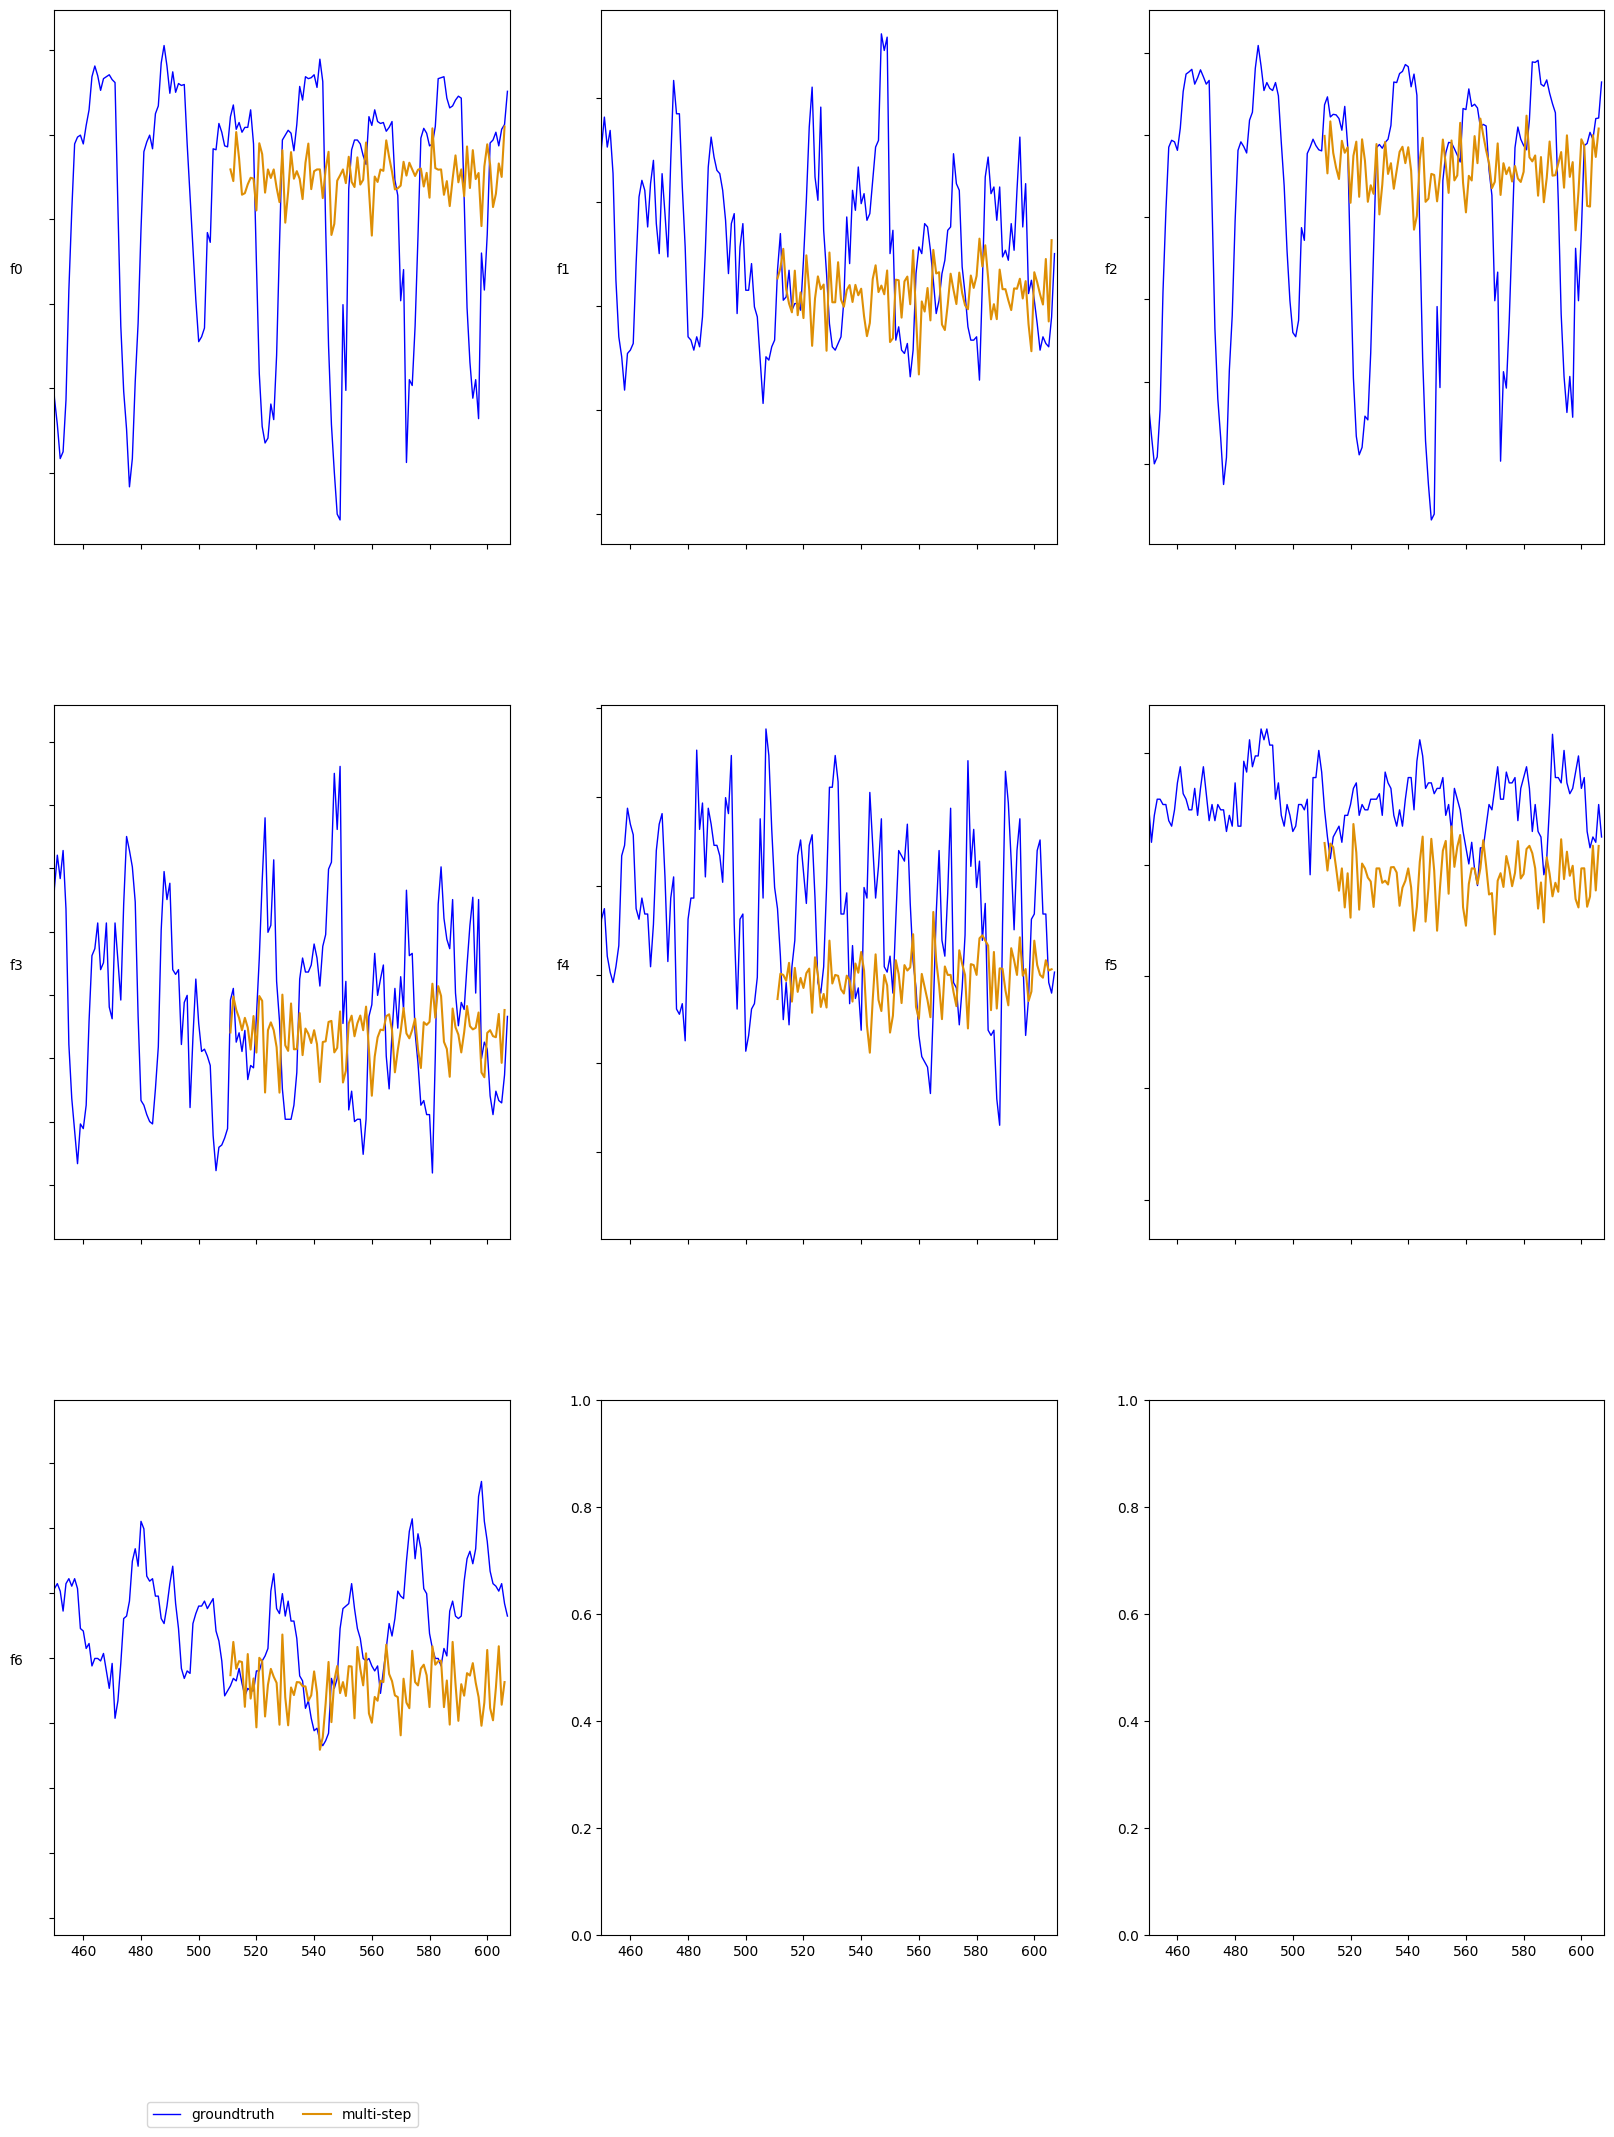

In [82]:
DICL.plot_multi_step(sample=0, xlim=[450, context_length])